In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["figure.dpi"] = 120

DATA_DIR = Path("./build")

FILES = {
    "summary": DATA_DIR / "hfO2_vacancy_summary.csv",
    "vacmap":  DATA_DIR / "hfO2_vacancy_map.csv",
    "edep":    DATA_DIR / "hfO2_edep_voxels.csv",
}

for k, p in FILES.items():
    if not p.exists():
        print(f"[WARN] Not found: {p}")


In [70]:
def read_summary(path: Path) -> dict:
    df = pd.read_csv(path)
    # формат key,value
    d = {}
    for _, row in df.iterrows():
        key = str(row["key"])
        val = row["value"]
        # попытка привести к числу
        try:
            val = float(val)
            # если целое, сделать int
            if abs(val - int(val)) < 1e-12:
                val = int(val)
        except Exception:
            pass
        d[key] = val
    return d

summary = read_summary(FILES["summary"])
vacmap  = pd.read_csv(FILES["vacmap"])
edepmap = pd.read_csv(FILES["edep"])

print("=== SUMMARY ===")
for k in ["nPrimaries", "totalCreated", "createdPerPrimary", "seedCapturedElectrons", "W_eV", "Ea_base_eV", "Ea_fast_eV"]:
    if k in summary:
        print(f"{k:>20}: {summary[k]}")
        
print("\n=== VACMAP columns ===", list(vacmap.columns))
print("=== EDEPMAP columns ===", list(edepmap.columns))
print("\nVACMAP head:")
display(vacmap.head())


=== SUMMARY ===
          nPrimaries: 1000
        totalCreated: 302
   createdPerPrimary: 0.302
seedCapturedElectrons: 2
                W_eV: 15
          Ea_base_eV: 2
          Ea_fast_eV: 1.3

=== VACMAP columns === ['ix', 'iy', 'iz', 'isVacancy', 'Ebank_eV', 'edepRun_eV', 'seed']
=== EDEPMAP columns === ['ix', 'iy', 'iz', 'edepRun_eV', 'seed']

VACMAP head:


,ix,iy,iz,isVacancy,Ebank_eV,edepRun_eV,seed
0,0,0,0,0,0.0,0.0,0
1,0,0,1,0,0.0,0.0,0
2,0,0,2,0,0.0,0.0,0
3,0,0,3,0,0.0,0.0,0
4,0,0,4,0,0.0,0.0,0


In [71]:
# важные параметры сетки берём из данных
Nx = int(vacmap["ix"].max() + 1)
Ny = int(vacmap["iy"].max() + 1)
Nz = int(vacmap["iz"].max() + 1)

# Толщина HfO2
dz_nm = 1.0

vacmap = vacmap.copy()
d_nm = Nz * dz_nm
#vacmap["depth_from_top_nm"] = d_nm - (vacmap["iz"] + 0.5) * dz_nm
vacmap["depth_nm"] = d_nm - (vacmap["iz"] + 0.5) * dz_nm

# Вакансии (isVacancy==1), исключая seed
vac_only = vacmap[vacmap["isVacancy"] == 1].copy()
created_only = vac_only[vac_only["seed"] == 0].copy()

print(f"Nx,Ny,Nz = {Nx},{Ny},{Nz}")
print(f"Total voxels: {len(vacmap)}")
print(f"Voxels with vacancy (incl seed): {len(vac_only)}")
print(f"Created vacancies (excl seed): {len(created_only)}")


Nx,Ny,Nz = 500,500,100
Total voxels: 25000000
Voxels with vacancy (incl seed): 303
Created vacancies (excl seed): 302


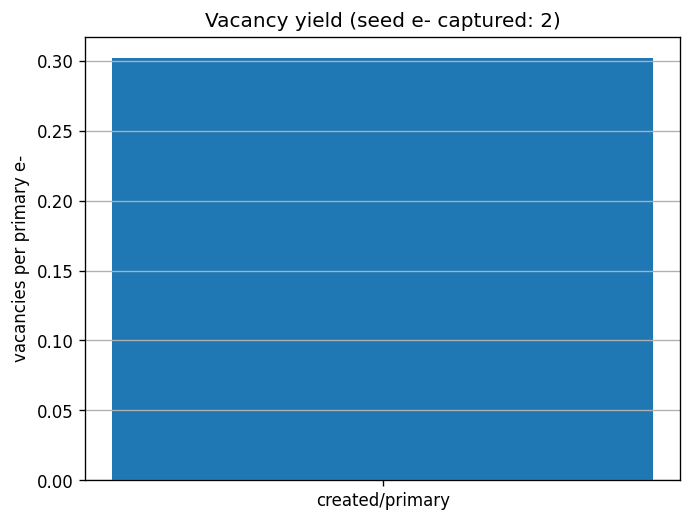

In [72]:
created_per_primary = summary.get("createdPerPrimary", np.nan)
seed_ne = summary.get("seedCapturedElectrons", np.nan)

fig = plt.figure()
plt.bar(["created/primary"], [created_per_primary])
plt.ylabel("vacancies per primary e-")
plt.title(f"Vacancy yield (seed e- captured: {seed_ne})")
plt.grid(True, axis="y")
plt.show()


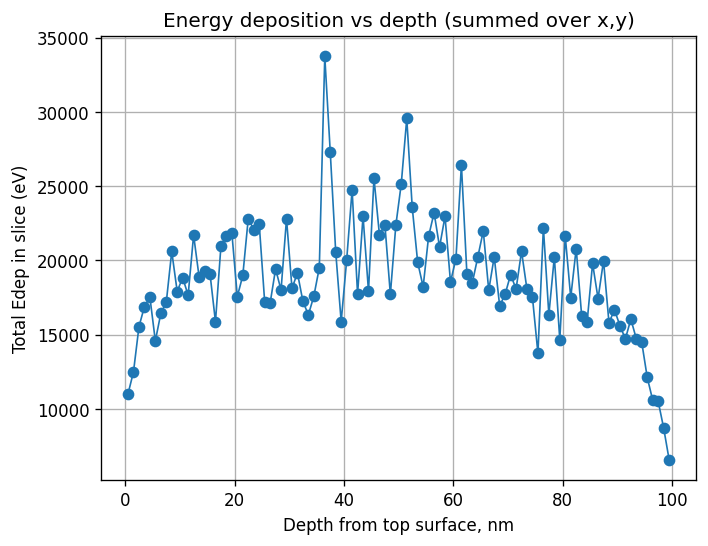

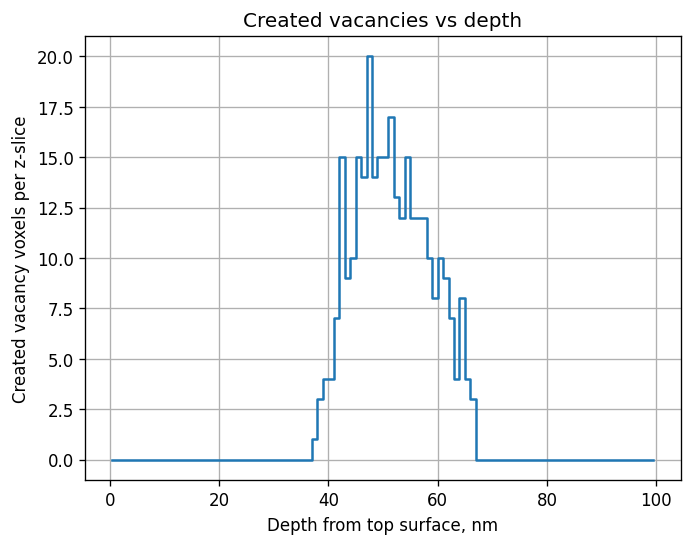

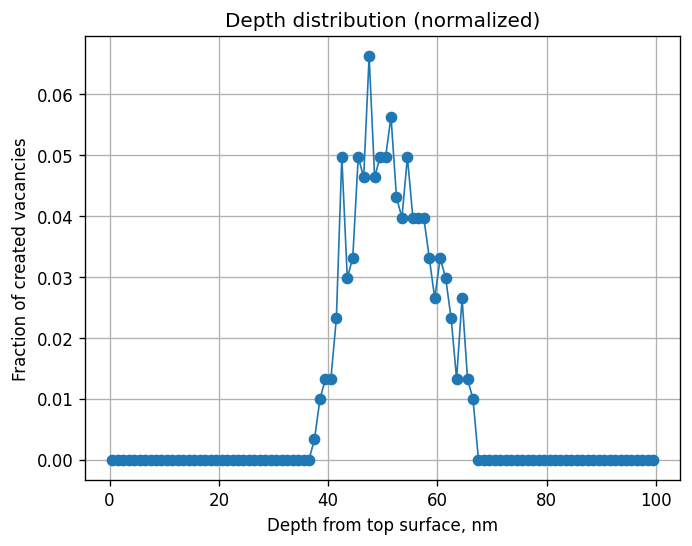

In [73]:
# Суммарное Edep по z (берём из vacmap колонку edepRun_eV)
edep_z = vacmap.groupby("iz", as_index=False)["edepRun_eV"].sum()
edep_z["depth_nm"] = (edep_z["iz"] + 0.5) * dz_nm

# Число вакансий по z (воксельный счёт)
vac_z = vac_only.groupby("iz", as_index=False).size().rename(columns={"size": "n_vac_vox"})
vac_z["depth_nm"] = (vac_z["iz"] + 0.5) * dz_nm

created_z = created_only.groupby("iz", as_index=False).size().rename(columns={"size": "n_created_vox"})
created_z["depth_nm"] = (created_z["iz"] + 0.5) * dz_nm

# Объединим
prof = edep_z.merge(vac_z[["iz","n_vac_vox"]], on="iz", how="left").merge(created_z[["iz","n_created_vox"]], on="iz", how="left")
prof = prof.fillna(0)

fig = plt.figure()
plt.plot(prof["depth_nm"], prof["edepRun_eV"], marker="o", linewidth=1)
plt.xlabel("Depth from top surface, nm")
plt.ylabel("Total Edep in slice (eV)")
plt.title("Energy deposition vs depth (summed over x,y)")
plt.grid(True)
plt.show()

fig = plt.figure()
plt.step(prof["depth_nm"], prof["n_created_vox"], where="mid")
plt.xlabel("Depth from top surface, nm")
plt.ylabel("Created vacancy voxels per z-slice")
plt.title("Created vacancies vs depth")
plt.grid(True)
plt.show()

# Нормированная доля созданных вакансий по глубине
if prof["n_created_vox"].sum() > 0:
    fig = plt.figure()
    plt.plot(prof["depth_nm"], prof["n_created_vox"] / prof["n_created_vox"].sum(), marker="o", linewidth=1)
    plt.xlabel("Depth from top surface, nm")
    plt.ylabel("Fraction of created vacancies")
    plt.title("Depth distribution (normalized)")
    plt.grid(True)
    plt.show()


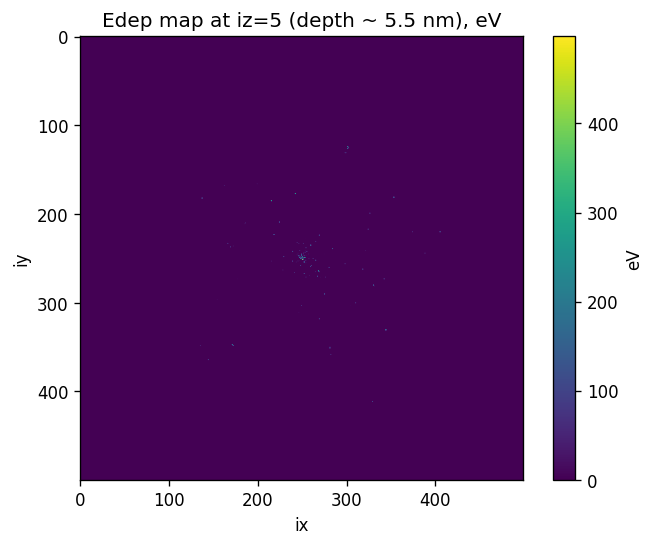

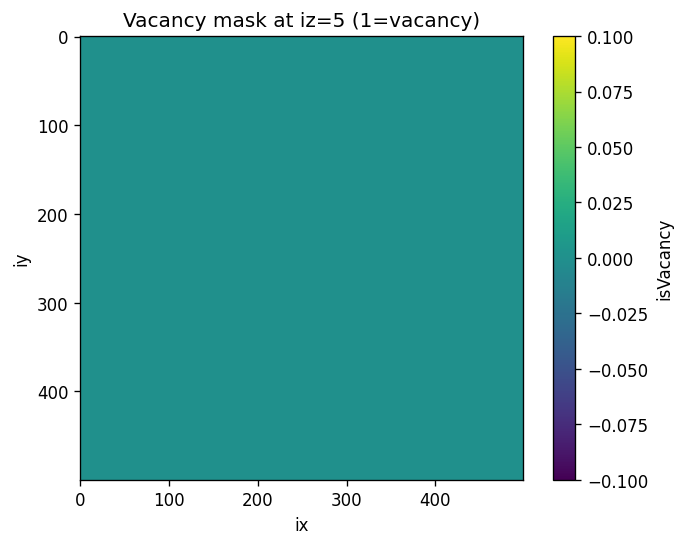

In [74]:
def pivot_slice(df: pd.DataFrame, iz: int, value_col: str):
    sl = df[df["iz"] == iz].pivot(index="iy", columns="ix", values=value_col)
    # index iy растёт вверх, но imshow ожидает [rol. col] сверху вниз -> делаем flip по y для удобства
    arr = sl.to_numpy()[::-1, :]
    return arr

def show_slice_maps(iz: int):
    edep = pivot_slice(vacmap, iz, "edepRun_eV")
    vac  = pivot_slice(vacmap, iz, "isVacancy")

    fig = plt.figure()
    plt.imshow(edep, aspect="equal")
    plt.title(f"Edep map at iz={iz} (depth ~ {(iz+0.5)*dz_nm:.1f} nm), eV")
    plt.colorbar(label="eV")
    plt.xlabel("ix")
    plt.ylabel("iy")
    plt.show()

    fig = plt.figure()
    plt.imshow(vac, aspect="equal")
    plt.title(f"Vacancy mask at iz={iz} (1=vacancy)")
    plt.colorbar(label="isVacancy")
    plt.xlabel("ix")
    plt.ylabel("iy")
    plt.show()

# Выбор z-среза:
# - iz=0 у верхней поверхности
# - iz=Nz-1 у нижней границы HfO2
iz_show = min(5, Nz-1)  # тут 5 нм в глубину
show_slice_maps(iz_show)


In [75]:
def centroid_depth(df_vac: pd.DataFrame) -> float:
    # Средняя глубина созданных вакансий
    if len(df_vac) == 0:
        return np.nan
    return float(np.average(df_vac["depth_nm"]))

def peak_depth(prof_df: pd.DataFrame) -> float:
    if prof_df["n_created_vox"].sum() == 0:
        return np.nan
    iz_peak = int(prof_df.loc[prof_df["n_created_vox"].idxmax(), "iz"])
    return (iz_peak + 0.5) * dz_nm

print("=== Quick diagnostics ===")
print("Mean depth of created vacancies (nm):", centroid_depth(created_only))
print("Peak depth of created vacancies (nm):", peak_depth(prof))
print("Total Edep in HfO2 (eV):", vacmap["edepRun_eV"].sum())
print("Total Edep per primary (eV):", vacmap["edepRun_eV"].sum() / summary.get("nPrimaries", 1))


=== Quick diagnostics ===
Mean depth of created vacancies (nm): 48.211920529801326
Peak depth of created vacancies (nm): 47.5
Total Edep in HfO2 (eV): 1881322.3529172996
Total Edep per primary (eV): 1881.3223529172997
